# 1. Background of Excellence in Research Award (Phase II)

![Example Image](https://i.ibb.co/2WqHdXy/Phase-II-partner-logo-bar-v2.png)

Climate change is a globally relevant, urgent, and multi-faceted issue heavily impacting many industries and aspects of public life. Participants in Phase II will have the opportunity to examine the climate change from different perspectives. Participants will choose to explore one dataset among several, spanning sectors including healthcare, energy and environmental protection. Participants will also have opportunities to take deeper dives into their dataset and tackle a range of impactful real-world tasks.

Phase II participants will be able to choose one of three research tracks to explore:
- ->US Environmental Protection Agency (EPA): weather, air pollutant, and census data
- MIT Critical Data: CDC county level COVID data
- Climate Change AI: Fine grained building energy usage data

Description of the data:

This dataset represents daily air quality measurements in the United States for 2019 and 2020 in EPA’s Air Quality System (AQS, https://www.epa.gov/aqs) database in which both PM2.5 and ozone are measured concurrently.  These PM2.5 and ozone concentration data are joined with locational, meteorological, demographic information, and concentrations of other major air quality pollutants when available.  All of the data were downloaded from AQS with the exception of four demographic parameters (people of color, low income, linguistically isolated, and less than high school education) which come from EPA’s EJSCREEN tool (https://www.epa.gov/ejscreen).  These demographic parameters are at the Census "block group" level (area defined by the Census Bureau that usually has between 600 and 3,000 people) and listed in fractional units for the block group containing the monitor location. 

# 2. Import Libraries, Define Functions

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# set the default precision to one decimal place
pd.set_option('display.float_format', '{:.2f}'.format)

In [11]:
def load_data():
    # Traverse through directory
    file_paths = []
    for dirname, _, filenames in os.walk('epa'):
        for filename in filenames:
            file_paths.append(os.path.join(dirname, filename))
    
    # Load Data
    air_2019 = pd.read_excel(file_paths[-1])
    air_2020 = pd.read_excel(file_paths[-2])
    
    # Specify STATE and COUNTY (Los Angeles and Riverside)
    air_LA_2019 = air_2019[(air_2019['STATE'] == 'California') & (air_2019['COUNTY'] == 'Los Angeles')]
    air_LA_2020 = air_2020[(air_2020['STATE'] == 'California') & (air_2020['COUNTY'] == 'Los Angeles')]
    
    air_RS_2019 = air_2019[(air_2019['STATE'] == 'California') & (air_2019['COUNTY'] == 'Riverside')]
    air_RS_2020 = air_2020[(air_2020['STATE'] == 'California') & (air_2020['COUNTY'] == 'Riverside')]
    
    # Merge 2019 and 2020 datasets
    df_LA_merged = pd.concat([air_LA_2019, air_LA_2020])
    df_RS_merged = pd.concat([air_RS_2019, air_RS_2020])

    return df_LA_merged, df_RS_merged

def preprocess(df, df_RS):
    # Change DATE column to pandas datetime
    df['datetime'] = pd.to_datetime(df['DATE'])
    # Sort data by datetime
    df_sorted = df.sort_values('datetime')
    # To tackle duplicates, group by datetime
    df_grouped = df_sorted.groupby('datetime').mean()
    
    # Drop unnecessary columns
    # Since we are only looking at a specific location, geographic data will be constant
    # Demographic data will also be constant
    # Other atmospheric data are too sparse with too many empty records, so we will drop them
    df_dropped = df_grouped.drop(['LATITUDE', 'LONGITUDE','PEOPLE_OF_COLOR_FRACTION',
                                  'LOW_INCOME_FRACTION', 'LINGUISTICALLY_ISOLATED_FRACTION',
                                  'LESS_THAN_HS_ED_FRACTION', 'LEAD_UG_PER_CUBIC_METER', 'BENZENE_PPBC',
                                  'WIND_DIRECTION', 'RELATIVE_HUMIDITY'], axis=1)
    
    # Preprocess/fill in data for SO2
    df_dropped = preprocess_so2(df_dropped)
    # Preprocess/fill in data for Temperature
    df_dropped = preprocess_temp(df_dropped, df_RS)
    
    # Select the columns with null values
    null_counts = df_dropped.isnull().sum()
    null_columns = null_counts[null_counts > 0].index
    # Impute missing values using SimpleImputer from sklearn.impute module. Here, we will use mean imputation for simplicity
    imputer = SimpleImputer(strategy='mean')
    # Apply mean imputation to the selected columns with null values
    df_dropped[null_columns] = imputer.fit_transform(df_dropped[null_columns])
    
    # Resample the DataFrame to include all dates and forward-fill missing values
    df_dropped = df_dropped.resample('D').ffill()
    # Fill in any remaining missing values with the previous value
    df_dropped = df_dropped.fillna(method='ffill')
    
    # Re-organize columns so that target variable is first column
    df_preprocessed = df_dropped.reindex(columns=['PM25_UG_PER_CUBIC_METER','TEMPERATURE_CELSIUS',
                                             'WIND_SPEED_METERS_PER_SECOND',
                                             'OZONE_PPM', 'NO2_PPB', 'CO_PPM', 'SO2_PPB'])
    
    return df_preprocessed

def preprocess_so2(df):
    # Extract the 'NO2' and 'SO2' columns
    no2_values = df['NO2_PPB']
    so2_values = df['SO2_PPB']

    # Standardize the 'NO2' and 'SO2' values
    scaler = StandardScaler()
    no2_values_norm = scaler.fit_transform(no2_values.values.reshape(-1, 1))
    so2_values_norm = scaler.fit_transform(so2_values.values.reshape(-1, 1))

    # Replace missing 'SO2' values with the corresponding 'NO2' values
    so2_values_norm = pd.Series(so2_values_norm.flatten(), index=so2_values.index)
    no2_values_norm = pd.Series(no2_values_norm.flatten(), index=no2_values.index)
    so2_values_norm = so2_values_norm.fillna(no2_values_norm)

    # Inverse transform the normalized 'SO2' values
    so2_values = scaler.inverse_transform(so2_values_norm.values.reshape(-1, 1))

    # Update the 'SO2' column in the DataFrame
    df['SO2_PPB'] = so2_values
    
    return df

def preprocess_temp(df, df_RS):
    df_RS['datetime'] = pd.to_datetime(df_RS['DATE'])
    df_RS_sorted = df_RS.sort_values('datetime')
    air_RS = df_RS_sorted.groupby('datetime').mean()

    for i, row in df[df['TEMPERATURE_CELSIUS'].isna()].iterrows():
        df.loc[i]['TEMPERATURE_CELSIUS'] = air_RS.loc[i]['TEMPERATURE_CELSIUS']
    
    return df

def vif(df):
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif["features"] = df.columns

    # print the VIF dataframe
    print(vif)

def heatmap(df, width=8, height=8):
    fig, ax = plt.subplots(figsize=(width, height))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax)

def univariate_plot(df, y, width=8, height=6):
    plt.plot(df[y])
    
    fig = plt.gcf()
    fig.set_size_inches(width, height)
    plt.ylabel(y)
    plt.show()

def multivariate_plot(df, y1, y2, width=8, height=6, norm=False):
    df_copy = df.copy()
    
    if norm == True:
        scaler = StandardScaler()
        df_copy[[y1,y2]] = scaler.fit_transform(df_copy[[y1,y2]])
    
    df_copy.plot(y=[y1, y2])
    
    fig = plt.gcf()
    fig.set_size_inches(width, height)
    
    plt.legend([y1, y2])
    plt.show() 
    
def scatter_plot(df, x, y, width=6, height=6):
    # Scatterplot of PM2.5 levels and temperature
    sns.scatterplot(data=df, x=x, y=y)
    
    # create a figure object with a size of 10 inches by 8 inches
    fig = plt.gcf()
    fig.set_size_inches(width, height)
    
    # Labels
    plt.title(f'Scatterplot of {x} and {y}')
    plt.xlabel(x)
    plt.ylabel(y)
    
    plt.show()

# 3. Load and Preprocess Data

In [12]:
df_LA, df_RS = load_data()

/var/folders/17/ckkw64wx5qs6yt81682v0rmw0000gn/T/ipykernel_9952/2302260260.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_LA_merged = air_LA_2019.append(air_LA_2020)
/var/folders/17/ckkw64wx5qs6yt81682v0rmw0000gn/T/ipykernel_9952/2302260260.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_RS_merged = air_RS_2019.append(air_RS_2020)


In [13]:
df_preprocessed = preprocess(df_LA, df_RS)

In [14]:
df_preprocessed

,PM25_UG_PER_CUBIC_METER,TEMPERATURE_CELSIUS,WIND_SPEED_METERS_PER_SECOND,OZONE_PPM,NO2_PPB,CO_PPM,SO2_PPB
datetime,,,,,,,
2019-01-01,9.55,6.60,1.43,0.03,13.36,0.45,0.45
2019-01-02,9.55,6.60,1.43,0.03,13.36,0.45,0.45
2019-01-03,8.32,10.55,1.42,0.03,25.79,0.62,0.44
2019-01-04,12.60,8.61,2.04,0.02,27.74,0.76,0.61
2019-01-05,13.85,8.25,2.35,0.03,20.11,0.65,0.43
...,...,...,...,...,...,...,...
2020-12-26,18.26,12.95,0.85,0.03,18.31,0.65,0.18
2020-12-27,19.60,14.05,1.53,0.03,12.86,0.38,0.04
2020-12-28,2.80,13.15,1.53,0.03,9.59,0.21,0.00


# 4. Feature Engineering

### 4.1 Add weekday and weekend variables

In [10]:
# Create flags based on day of the week
# 2019-01-01 = Tuesday
# 2019-01-02 = Wednesday
# 2019-01-03 = Thursday
# 2019-01-04 = Friday
# 2019-01-05 = Sataturday
# 2019-01-06 = Sunday

In [11]:
df_preprocessed.columns

Index(['PM25_UG_PER_CUBIC_METER', 'TEMPERATURE_CELSIUS',
       'WIND_SPEED_METERS_PER_SECOND', 'OZONE_PPM', 'NO2_PPB', 'CO_PPM',
       'SO2_PPB'],
      dtype='object')

In [5]:
df_preprocessed_days = df_preprocessed.copy()

df_preprocessed_days["monday"] = 0
df_preprocessed_days["monday"][6::7] = 1

df_preprocessed_days["tuesday"] = 0
df_preprocessed_days["tuesday"][0::7] = 1

df_preprocessed_days["wednesday"] = 0
df_preprocessed_days["wednesday"][1::7] = 1

df_preprocessed_days["thursday"] = 0
df_preprocessed_days["thursday"][2::7] = 1

df_preprocessed_days["friday"] = 0
df_preprocessed_days["friday"][3::7] = 1

df_preprocessed_days["saturday"] = 0
df_preprocessed_days["saturday"][4::7] = 1

df_preprocessed_days["sunday"] = 0
df_preprocessed_days["sunday"][5::7] = 1

df_preprocessed_days["weekend"] = df_preprocessed_days["saturday"] + df_preprocessed_days["sunday"]
df_preprocessed_days["sudo_weekend"] = df_preprocessed_days["friday"]+ df_preprocessed_days["saturday"] + df_preprocessed_days["sunday"]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/co

In [6]:
df_preprocessed_days.head(20)

,PM25_UG_PER_CUBIC_METER,TEMPERATURE_CELSIUS,WIND_SPEED_METERS_PER_SECOND,OZONE_PPM,NO2_PPB,CO_PPM,SO2_PPB,monday,tuesday,wednesday,thursday,friday,saturday,sunday,weekend,sudo_weekend
datetime,,,,,,,,,,,,,,,,
2019-01-01,9.55,6.60,1.43,0.03,13.36,0.45,0.45,0,1,0,0,0,0,0,0,0
2019-01-02,9.55,6.60,1.43,0.03,13.36,0.45,0.45,0,0,1,0,0,0,0,0,0
2019-01-03,8.32,10.55,1.42,0.03,25.79,0.62,0.44,0,0,0,1,0,0,0,0,0
2019-01-04,12.60,8.61,2.04,0.02,27.74,0.76,0.61,0,0,0,0,1,0,0,0,1
2019-01-05,13.85,8.25,2.35,0.03,20.11,0.65,0.43,0,0,0,0,0,1,0,1,1
2019-01-06,5.23,10.87,1.26,0.04,8.48,0.30,0.05,0,0,0,0,0,0,1,1,1
2019-01-07,3.90,11.88,2.24,0.03,12.07,0.39,0.12,1,0,0,0,0,0,0,0,0
2019-01-08,6.85,11.97,2.26,0.03,19.63,0.55,0.26,0,1,0,0,0,0,0,0,0
2019-01-09,14.37,13.48,1.14,0.02,23.70,0.74,0.39,0,0,1,0,0,0,0,0,0


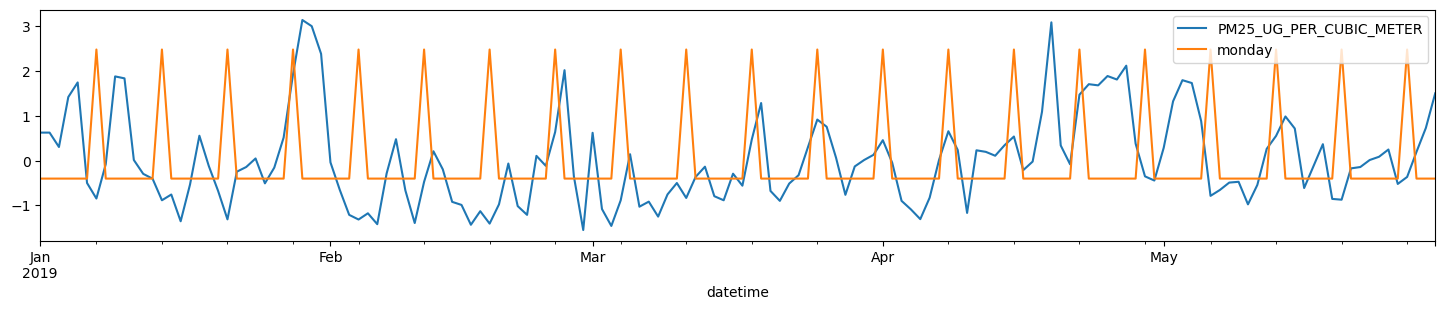

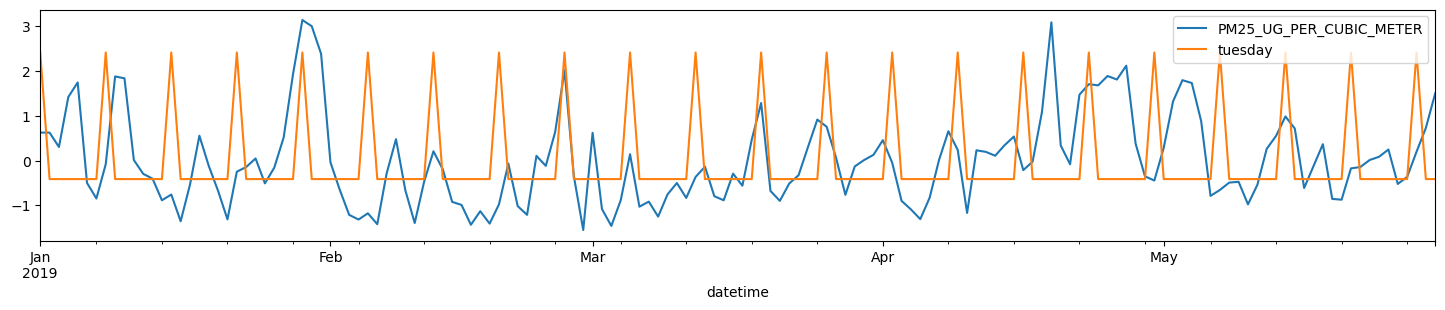

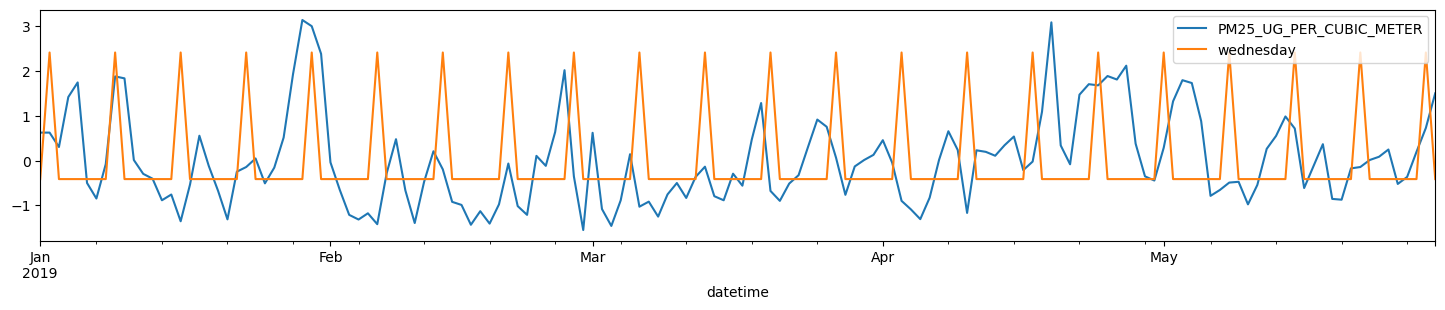

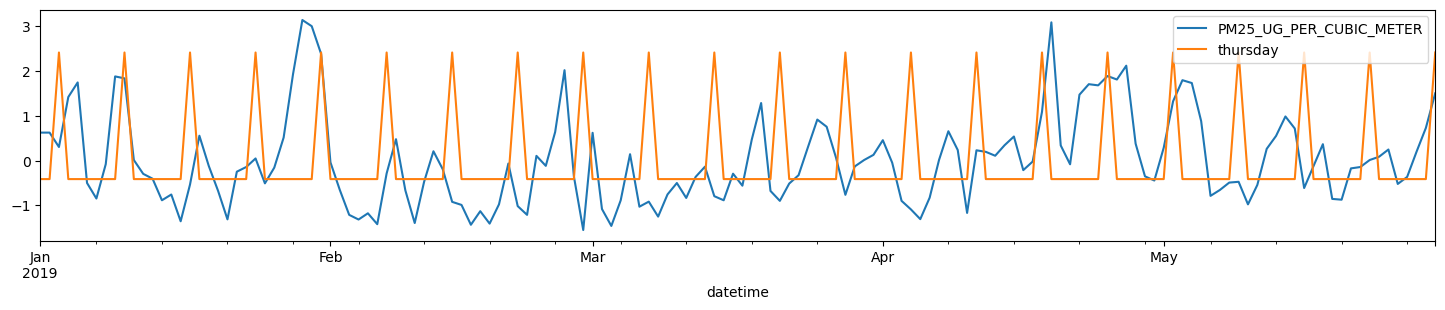

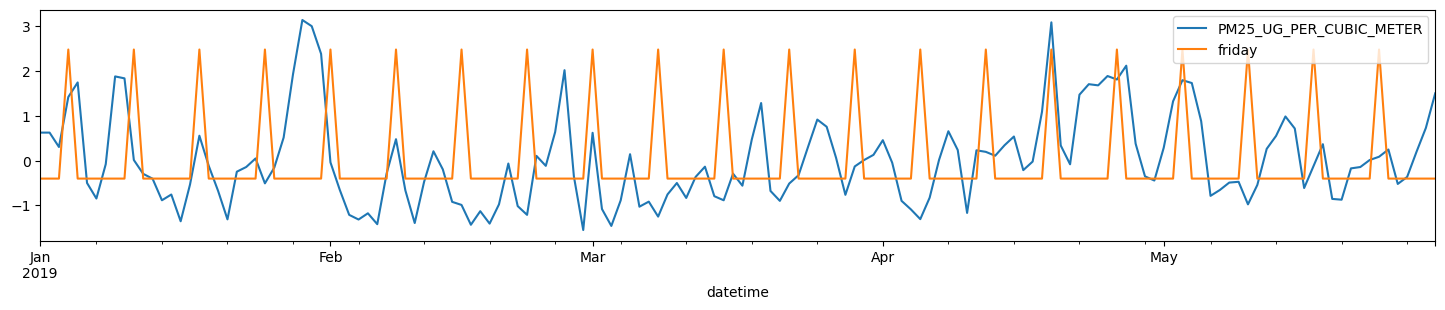

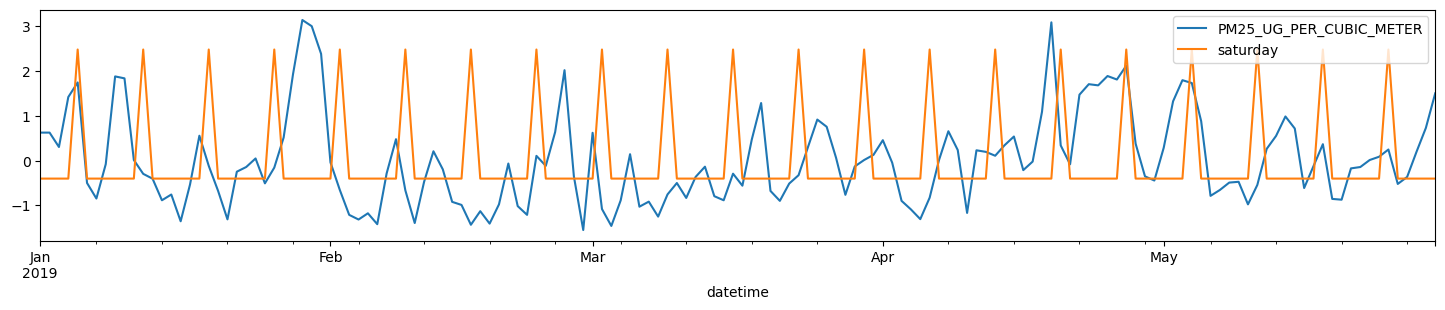

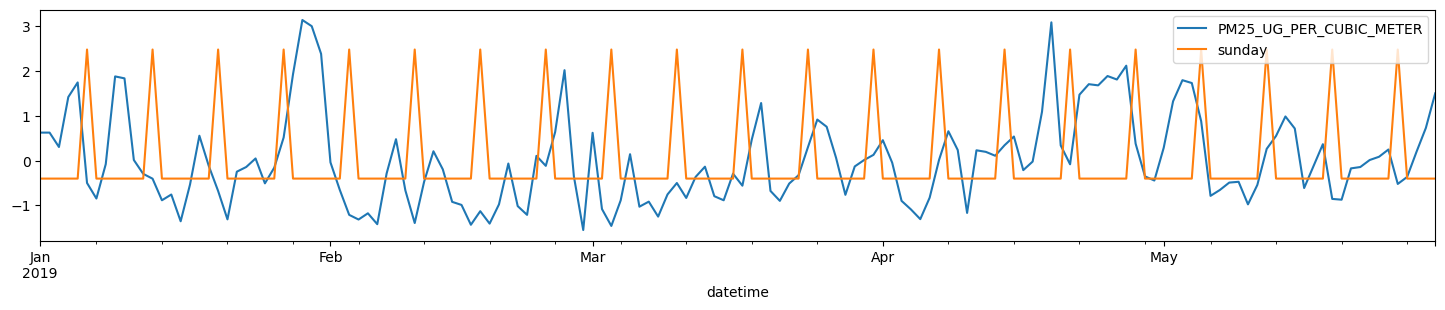

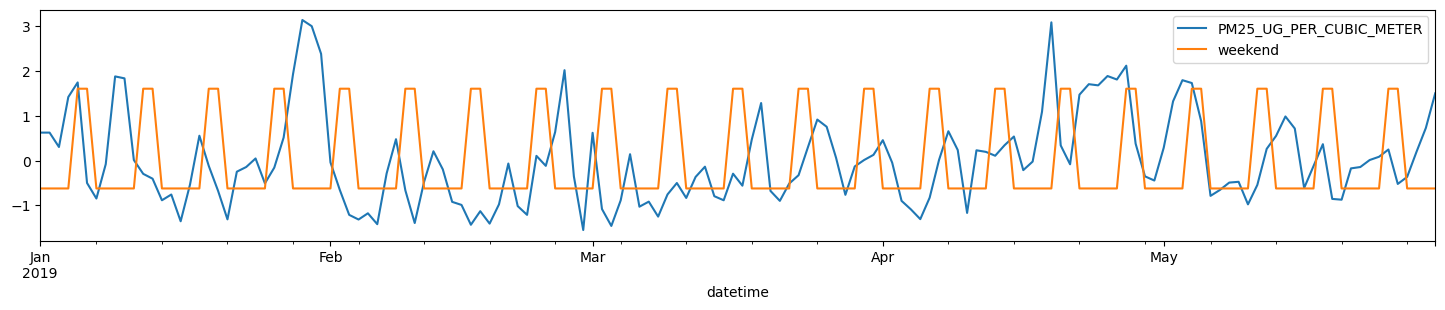

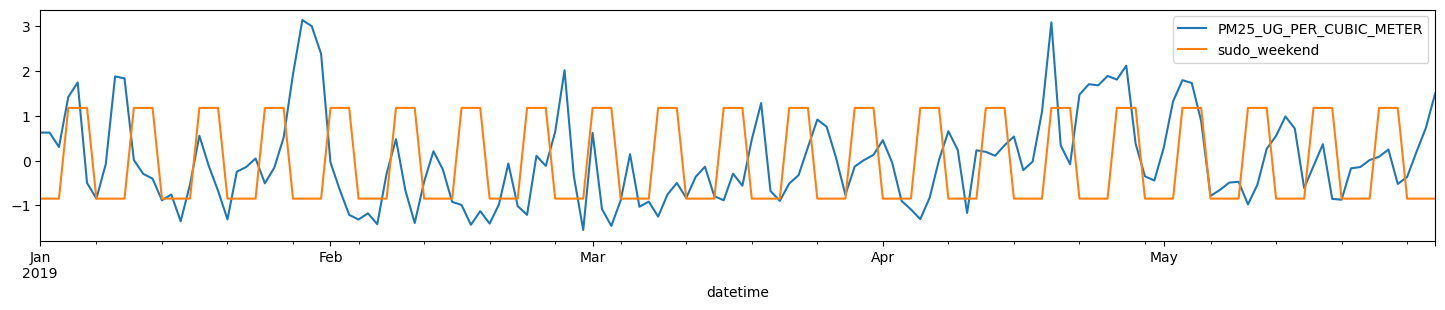

In [8]:
for day in ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday','sunday', 'weekend', 'sudo_weekend']:
    multivariate_plot(df_preprocessed_days[:150], 'PM25_UG_PER_CUBIC_METER', day, 18, 3, norm=True)

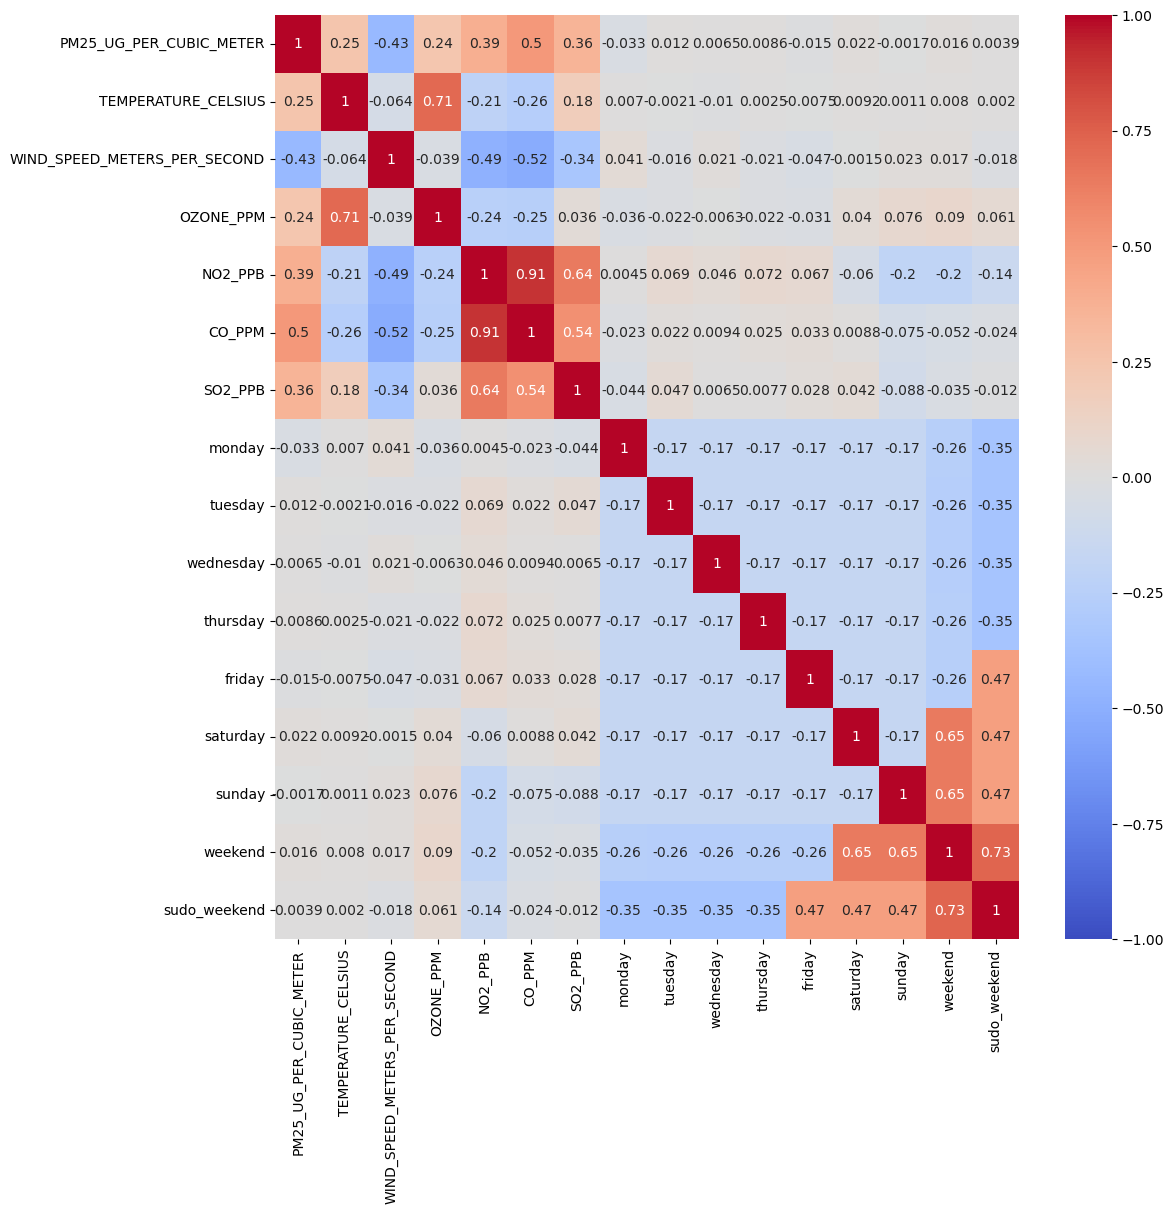

In [14]:
heatmap(df_preprocessed_days, 12, 12)

In [116]:
# Conclusion
# It seems like the day of the week is not an important factor, so we will not use them

### 4.2 Add Lagging Target Variable

In [9]:
df_preprocessed_lags = df_preprocessed.copy()

In [10]:
df_preprocessed_lags["PM25_1_week_ago"] = df_preprocessed_lags['PM25_UG_PER_CUBIC_METER'][0]
df_preprocessed_lags["PM25_1_week_ago"][7:] = df_preprocessed_lags['PM25_UG_PER_CUBIC_METER'][:-7]

In [11]:
df_preprocessed_lags[["PM25_UG_PER_CUBIC_METER", "PM25_1_week_ago"]].head(20)

,PM25_UG_PER_CUBIC_METER,PM25_1_week_ago
datetime,,
2019-01-01,9.55,9.55
2019-01-02,9.55,9.55
2019-01-03,8.32,9.55
2019-01-04,12.60,9.55
2019-01-05,13.85,9.55
2019-01-06,5.23,9.55
2019-01-07,3.90,9.55
2019-01-08,6.85,9.55
2019-01-09,14.37,9.55


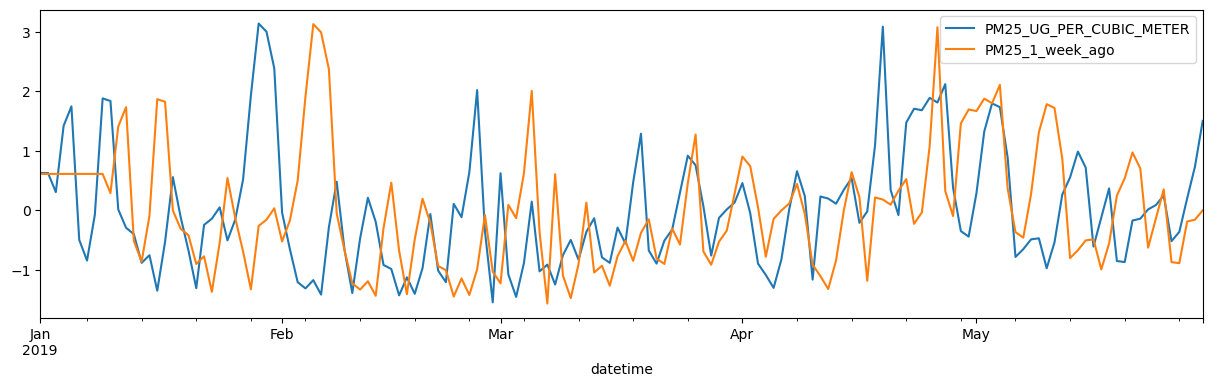

In [12]:
multivariate_plot(df_preprocessed_lags[:150], 'PM25_UG_PER_CUBIC_METER', 'PM25_1_week_ago', 15, 4, norm=True)

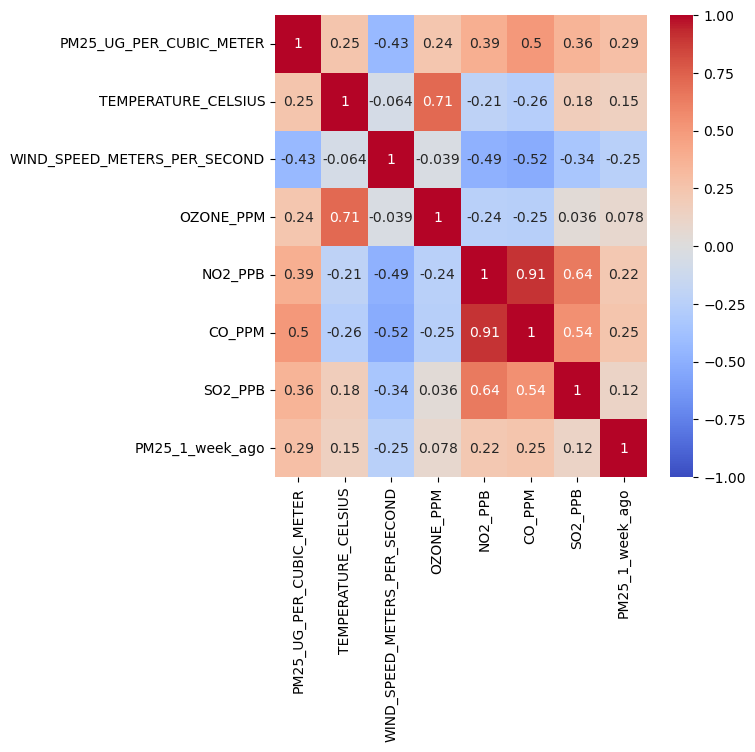

In [13]:
heatmap(df_preprocessed_lags, 6, 6)

In [14]:
vif(df_preprocessed_lags)

   VIF Factor                      features
0        6.22       PM25_UG_PER_CUBIC_METER
1       28.47           TEMPERATURE_CELSIUS
2        8.21  WIND_SPEED_METERS_PER_SECOND
3       26.92                     OZONE_PPM
4       31.25                       NO2_PPB
5       28.00                        CO_PPM
6        5.31                       SO2_PPB
7        3.80               PM25_1_week_ago


### 4.3 Take Log and Exponent of existing variables

In [23]:
df_preprocessed_lags.columns

Index(['PM25_UG_PER_CUBIC_METER', 'TEMPERATURE_CELSIUS',
       'WIND_SPEED_METERS_PER_SECOND', 'OZONE_PPM', 'NO2_PPB', 'CO_PPM',
       'SO2_PPB', 'PM25_1_week_ago'],
      dtype='object')

In [15]:
df_preprocessed_copy = df_preprocessed_lags.copy()

df_preprocessed_copy["TEMPERATURE_CELSIUS_sq"] = df_preprocessed_copy["TEMPERATURE_CELSIUS"] ** 2
df_preprocessed_copy["TEMPERATURE_CELSIUS_log"] = np.log10(df_preprocessed_copy["TEMPERATURE_CELSIUS"])

df_preprocessed_copy["WIND_SPEED_METERS_PER_SECOND_sq"] = df_preprocessed_copy["WIND_SPEED_METERS_PER_SECOND"] ** 2
df_preprocessed_copy["WIND_SPEED_METERS_PER_SECOND_log"] = np.log10(df_preprocessed_copy["WIND_SPEED_METERS_PER_SECOND"])

df_preprocessed_copy["OZONE_PPM_sq"] = df_preprocessed_copy["OZONE_PPM"] ** 2
df_preprocessed_copy["OZONE_PPM_log"] = np.log10(df_preprocessed_copy["OZONE_PPM"])

df_preprocessed_copy["NO2_PPB_sq"] = df_preprocessed_copy["NO2_PPB"] ** 2
df_preprocessed_copy["NO2_PPB_log"] = np.log10(df_preprocessed_copy["NO2_PPB"])

df_preprocessed_copy["CO_PPM_sq"] = df_preprocessed_copy["CO_PPM"] ** 2
df_preprocessed_copy["CO_PPM_log"] = np.log10(df_preprocessed_copy["CO_PPM"])

df_preprocessed_copy["SO2_PPB_sq"] = df_preprocessed_copy["SO2_PPB"] ** 2
df_preprocessed_copy["SO2_PPB_log"] = np.log10(df_preprocessed_copy["SO2_PPB"])

/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


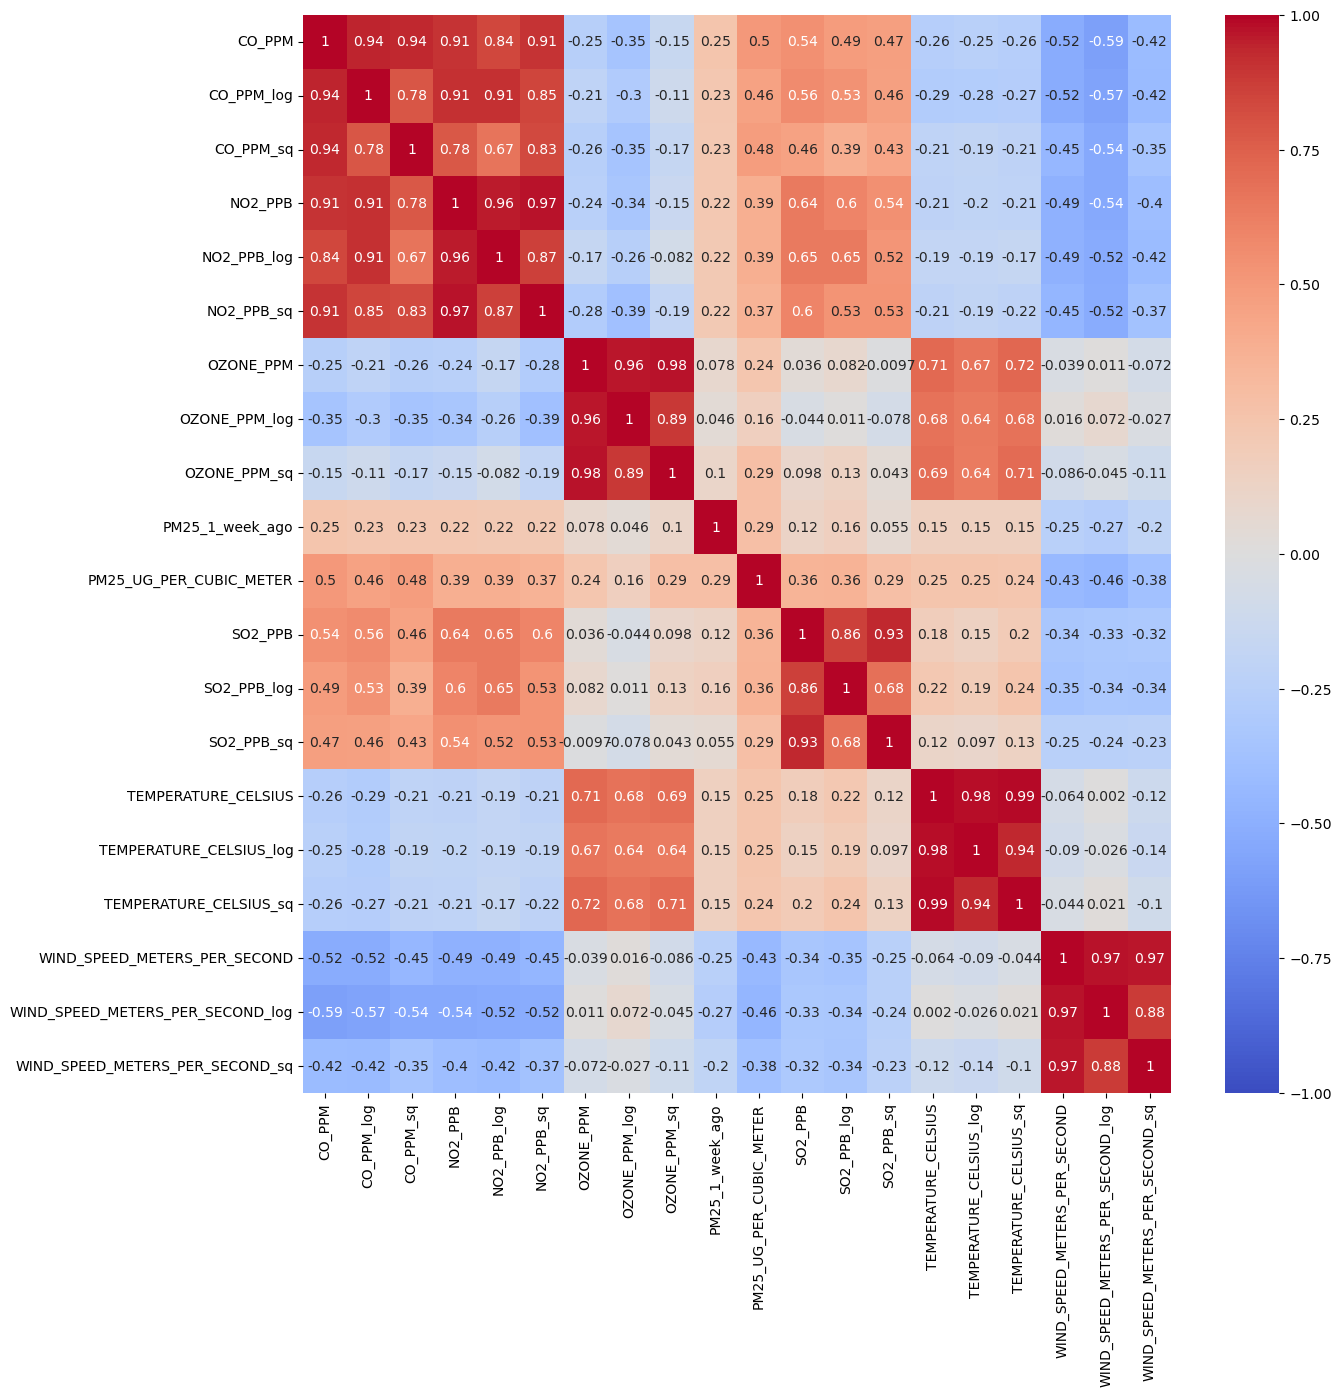

In [16]:
heatmap(df_preprocessed_copy[sorted(list(df_preprocessed_copy.columns))], 14, 14)

In [17]:
# We notice that some versions (sq and log) have higher correlation coefficient values that their original variable
df_preprocessed_copy[sorted(list(df_preprocessed_copy.columns))].corr()["PM25_UG_PER_CUBIC_METER"]

CO_PPM                              0.50
CO_PPM_log                          0.46
CO_PPM_sq                           0.48
NO2_PPB                             0.39
NO2_PPB_log                         0.39
NO2_PPB_sq                          0.37
OZONE_PPM                           0.24
OZONE_PPM_log                       0.16
OZONE_PPM_sq                        0.29
PM25_1_week_ago                     0.29
PM25_UG_PER_CUBIC_METER             1.00
SO2_PPB                             0.36
SO2_PPB_log                         0.36
SO2_PPB_sq                          0.29
TEMPERATURE_CELSIUS                 0.25
TEMPERATURE_CELSIUS_log             0.25
TEMPERATURE_CELSIUS_sq              0.24
WIND_SPEED_METERS_PER_SECOND       -0.43
WIND_SPEED_METERS_PER_SECOND_log   -0.46
WIND_SPEED_METERS_PER_SECOND_sq    -0.38
Name: PM25_UG_PER_CUBIC_METER, dtype: float64

In [ ]:
# Select feature variation with the highest (absolute) value
# CO_PPM                              0.50 o
# CO_PPM_log                          0.46
# CO_PPM_sq                           0.48
# NO2_PPB                             0.39 o
# NO2_PPB_log                         0.39
# NO2_PPB_sq                          0.37
# OZONE_PPM                           0.24
# OZONE_PPM_log                       0.16
# OZONE_PPM_sq                        0.29 o
# PM25_1_week_ago                     0.29 o
# PM25_UG_PER_CUBIC_METER             1.00 o
# SO2_PPB                             0.36 o
# SO2_PPB_log                         0.36
# SO2_PPB_sq                          0.29
# TEMPERATURE_CELSIUS                 0.25 o
# TEMPERATURE_CELSIUS_log             0.25
# TEMPERATURE_CELSIUS_sq              0.24
# WIND_SPEED_METERS_PER_SECOND       -0.43
# WIND_SPEED_METERS_PER_SECOND_log   -0.46 o
# WIND_SPEED_METERS_PER_SECOND_sq    -0.38

In [27]:
df = df_preprocessed_copy[["PM25_UG_PER_CUBIC_METER", "PM25_1_week_ago", "CO_PPM", "NO2_PPB", "OZONE_PPM_sq", "SO2_PPB", "TEMPERATURE_CELSIUS", "WIND_SPEED_METERS_PER_SECOND_log"]]

In [29]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PM25_UG_PER_CUBIC_METER,730.00,10.99,7.28,1.20,6.95,9.53,13.00,78.43
PM25_1_week_ago,730.00,10.97,7.26,1.20,6.97,9.54,12.92,78.43
CO_PPM,730.00,0.36,0.22,0.05,0.21,0.29,0.48,1.73
NO2_PPB,730.00,13.43,7.32,2.08,7.39,11.69,18.84,38.69
OZONE_PPM_sq,730.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
SO2_PPB,730.00,0.29,0.23,-0.06,0.10,0.24,0.43,1.38
TEMPERATURE_CELSIUS,730.00,18.00,5.42,3.98,13.64,17.62,22.64,34.55
WIND_SPEED_METERS_PER_SECOND_log,730.00,0.17,0.12,-0.29,0.10,0.18,0.25,0.60


In [30]:
df.columns

Index(['PM25_UG_PER_CUBIC_METER', 'PM25_1_week_ago', 'CO_PPM', 'NO2_PPB',
       'OZONE_PPM_sq', 'SO2_PPB', 'TEMPERATURE_CELSIUS',
       'WIND_SPEED_METERS_PER_SECOND_log'],
      dtype='object')

In [31]:
df_normed = df.copy()

# select the features to standardize
features = ['PM25_1_week_ago', 'CO_PPM', 'NO2_PPB',
            'OZONE_PPM_sq', 'SO2_PPB', 'TEMPERATURE_CELSIUS',
            'WIND_SPEED_METERS_PER_SECOND_log']

# initialize the scaler
scaler = StandardScaler()

# fit and transform the selected features
df_normed[features] = scaler.fit_transform(df_normed[features])

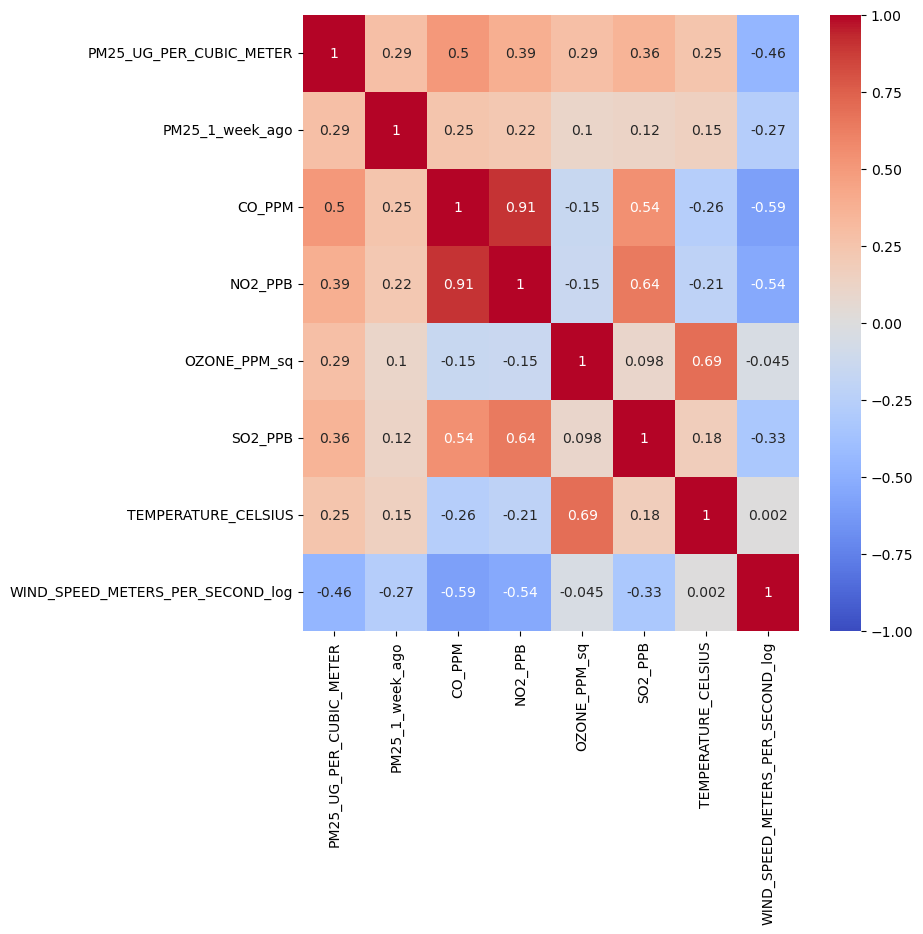

In [32]:
heatmap(df_normed)
# Seems like NO2 and CO are very similar (over 0.8). Let's decide which one to remove

In [33]:
vif(df_normed)
# CO has a lower VIF factor than NO2, therefore we will drop NO2
# We find that all other variables are under the VIF threshold of 10

   VIF Factor                          features
0        1.17           PM25_UG_PER_CUBIC_METER
1        1.16                   PM25_1_week_ago
2        6.80                            CO_PPM
3        7.04                           NO2_PPB
4        1.94                      OZONE_PPM_sq
5        2.11                           SO2_PPB
6        2.43               TEMPERATURE_CELSIUS
7        1.64  WIND_SPEED_METERS_PER_SECOND_log


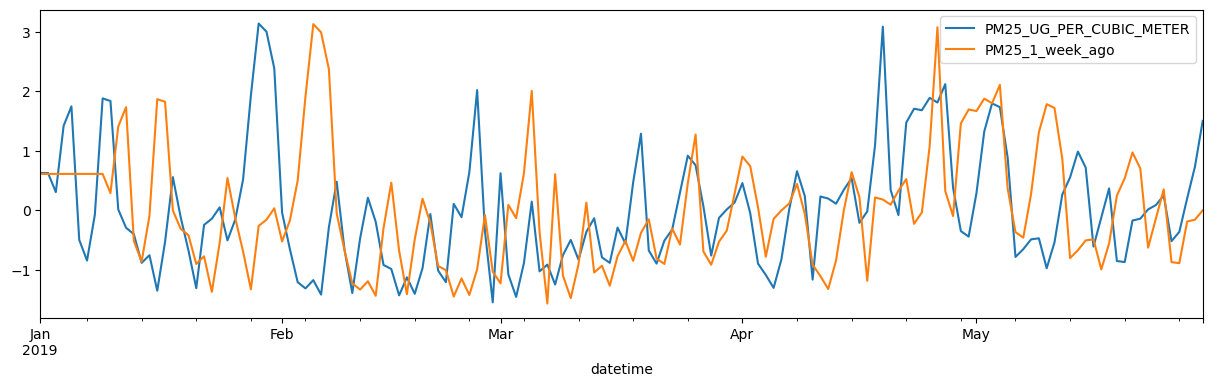

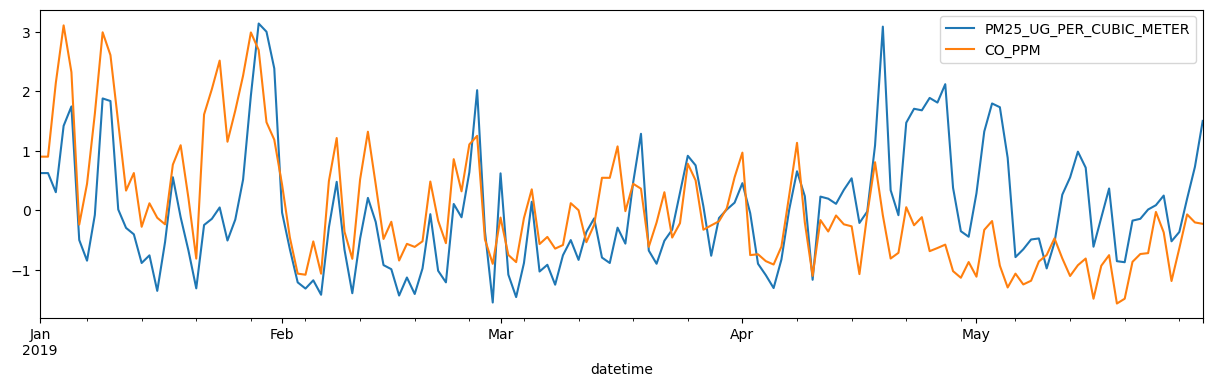

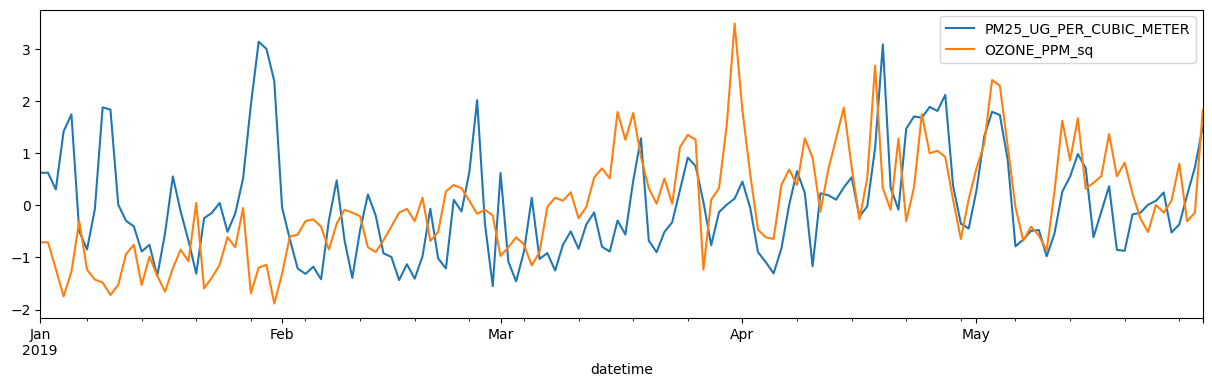

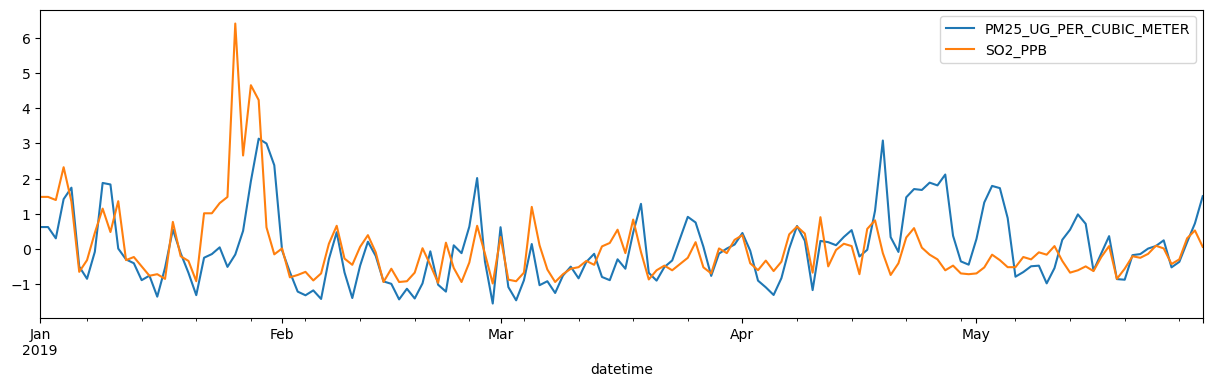

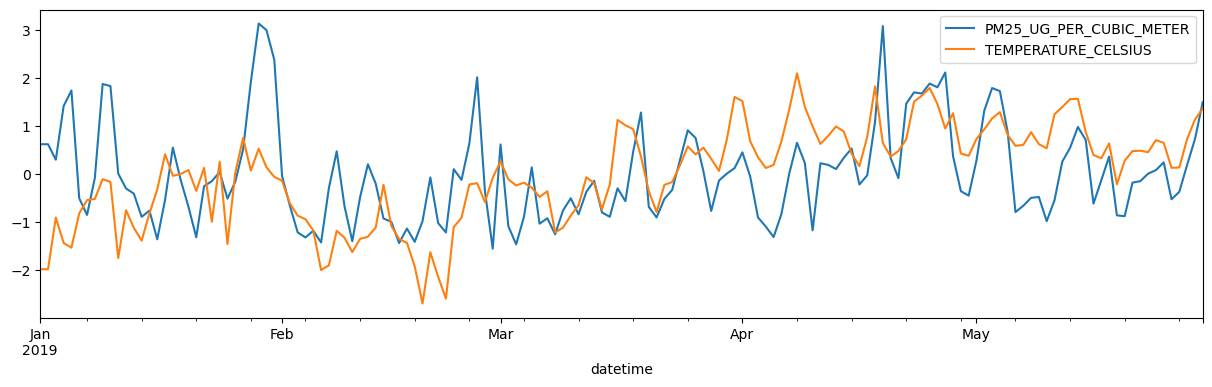

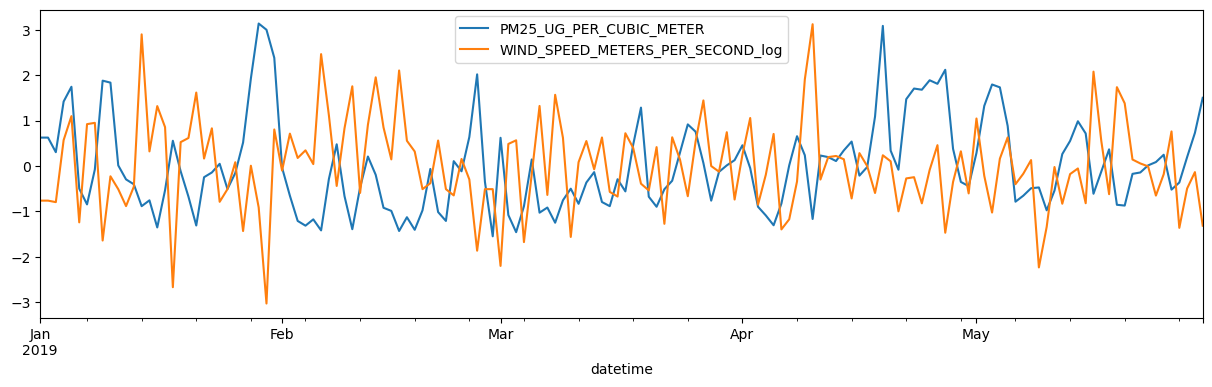

In [35]:
for feature in ['PM25_1_week_ago', 'CO_PPM', 'OZONE_PPM_sq', 'SO2_PPB', 'TEMPERATURE_CELSIUS', 'WIND_SPEED_METERS_PER_SECOND_log']:
    multivariate_plot(df_normed[:150], 'PM25_UG_PER_CUBIC_METER', feature, 15, 4, norm=True)

In [36]:
df = df_normed[['PM25_1_week_ago', 'CO_PPM', 'OZONE_PPM_sq', 'SO2_PPB', 'TEMPERATURE_CELSIUS', 'WIND_SPEED_METERS_PER_SECOND_log']]